# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment

#### install spp client to your local device: pip install -i https://pip.s2.allenai.org/simple spp_client

## 1. Get data from annotation store
Load data from schema into notebook.

In [152]:
import urllib.request, json 

# !!!! ANNOTATOR TODO: We will need to change SHA and annotation/attribute source for each paper evaluated
sha = '121e30c48546e671dc5e16c694c5e69b392cf8fb'

# get data from json file
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/pdf/{sha}/annotations?"
                            f"annotationSources=all&attributeSources=all") as url:
    data = json.load(url)

### 1a. Get source names and endpoint types
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [153]:
mention_detection_source: "citation_mentions-0.0.0|pdfplumber-0.0.5"
bib_mention_linker_source: "citation-links-0.0.0|citation_mentions-0.0.0|pdfplumber-0.0.5"
bib_detection_source: "bib-entry-detector-0.0.test|vila-0.0.2|pdfplumber-0.0.5"
pdf_plumber: "pdfplumber-0.0.5"
bib_parsing_source: "bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5"

### 1b. Retrieve Annotations for tokens, rows, and pages
Using the sources obtained from the previous cell, we will now retreive the annotations for each source depending on if they are in the annotation store as a PDF or plain text.

In [154]:
# !!!! ANNOTATOR TODO: Update with your path (if layoutparser package not working)
import sys
sys.path.append("/Users/baileyk/opt/anaconda3/envs/mmda/lib/python3.8/site-packages/") # get layoutparser path
import layoutparser 

In [155]:
# Get annotations using chrisW's spp client
from spp_client.client import DocumentAnnotations, SppClient

#change this
sha = '121e30c48546e671dc5e16c694c5e69b392cf8fb'

client = SppClient.mk(env="dev")
plumber_version = "pdfplumber-0.0.5"


lp = "layout-parser-0.0.2|pdfplumber-0.0.5"

doc_annos = [
    DocumentAnnotations(
        source=lp,
        annotation_type="blocks"
    ),
    
    DocumentAnnotations(
        source="vila-0.0.2|layout-parser-0.0.2|pdfplumber-0.0.5",
        annotation_type="vila_span_groups"
    ),
    
    DocumentAnnotations(
        source="citation_mentions-0.0.0|pdfplumber-0.0.5",
        annotation_type="citation_mentions"
    )
]

mmda_doc = client.get_mmda_doc(
    sha,
    plumber_version,
    doc_annos,
    include_images=True
)

#print(mmda_doc.blocks[0])
#print(mmda_doc.citation_mentions)

In [143]:
#raw Annotation Store data (may not need)
mmda_doc, as_pdf_annos, as_text_annos = client.get_mmda_and_as_docs(
    sha,
    plumber_version,
    doc_annos,
    include_images=True
)

#as_pdf_annos.attributesFromSource

#as_pdf_annos.annotationsFromSource["layout-parser-0.0.2|pdfplumber-0.0.5"]["blocks"][0].attributesFromSource

### 1c. Check to make sure you have annotated all fields onto mmda doc
Should be: 'tokens', 'pages', 'rows', 'blocks', 'vila_span_groups', 'citation_mentions'

In [144]:
print(mmda_doc.fields)

#print(mmda_doc.citation_mentions[0].spans)

['tokens', 'pages', 'rows', 'blocks', 'vila_span_groups', 'citation_mentions']


## 2. Visalize Paper and Draw boxes on mentions
Use draw boxes to visualize each mention

### 2a. Get Random page to annotate

In [156]:
# !!!! ANNOTATOR TODO: Record page # from output in annotation spreadsheet
# get random page number to review and annotate

import random # to get random page number to annotate
page = random.randrange(1,len(mmda_doc.pages)) 
print("page to annotate:", page)

page to annotate: 2


### 2b. Make boxgroups for mentions so that boxes can be drawn for them.

In [157]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
    
    for cite in mmda_doc.citation_mentions:
        for span in cite.spans:
            dictionary_of_boxes[span.box.page].append(span.box) 
    
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list

### 2c. Draw boxes given box groups.

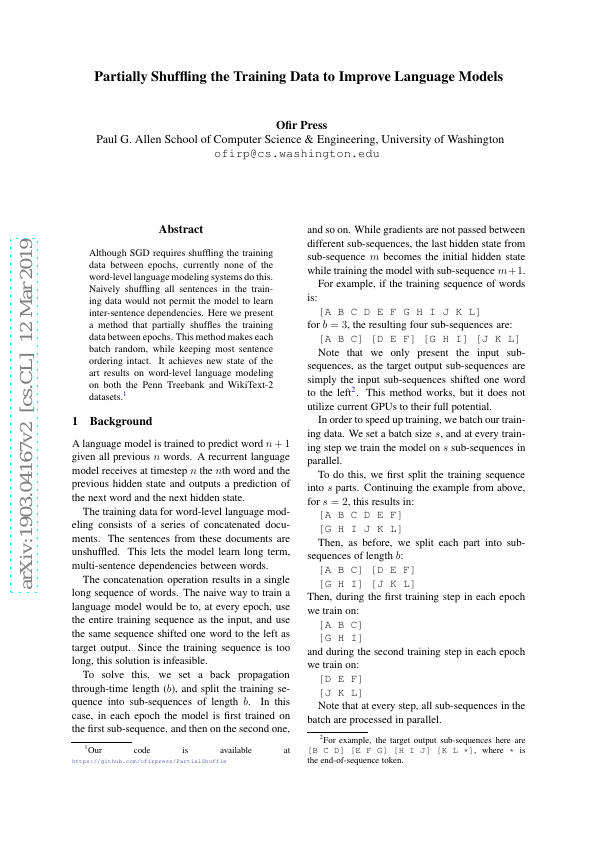

In [161]:
## can maybe use this to label mentions?
#viz = lp.draw_box(image, [ele.set(id=f"{ele.type}:{ele.score:.2f}") for ele in model_outputs], show_element_id=True)
#display(viz)

#egor version
def draw_boxgroups(image, rectangle_list, color_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'green', 'color_2': 'blue', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle, type=f'color_1')) #add id group here
        
    if image:
        return lpv.draw_box(image, viz, color_map=color_map, show_element_id=False)
    
    return None

#make boxes
dic_boxgroups = make_boxgroups_mentions(mmda_doc)

#this would display all pages of the pdf
"""for page in range(len(mmda_doc.images)):
    #draw boxes on the doc at each page in rectangle_list
    image = draw_boxgroups(mmda_doc.images[page], list(dictionary_of_boxes[page]))
    display(image)"""

#sp+
image = draw_boxgroups(mmda_doc.images[page], list(dic_boxgroups[page]))

display(image)

## 3. Get references and s2 id's for each mention.

Get the link data that exists in the annotation store as an attribute on the citation mention onto the citation mention spangroup, maybe as metadata